# Программная реализация машиного обучения для определения биомаркеров болезни Паркинсона по ЭЭГ

выполнила: Вахромеева Е.А., гр. 737-01

In [35]:
#%pip install openneuro-py mne mne_bids naplib autoreject --quiet

In [36]:
import os
import os.path as op
import numpy as np
import pandas as pd

import openneuro
import mne
from mne.viz import plot_topomap
from mne.datasets import sample
from mne import Epochs
from mne.decoding import SSD

from mne_bids import (
    BIDSPath,
    find_matching_paths,
    get_entity_vals,
    make_report,
    print_dir_tree,
    read_raw_bids,
)

import naplib as nl
from naplib.io import load_bids

from autoreject import AutoReject
from autoreject import get_rejection_threshold

from time import time

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.manifold import TSNE, MDS

import torch
from torch import tensor, nn
from torch.utils.data import DataLoader, Dataset as BaseDataset

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

Целью этой работы является обучить ML-модель определять наличие болезни Паркинсона по электроэнцефалограммам (ЭЭГ) пациентов.

### Что такое ЭЭГ и как она работает

ЭЭГ - это неинвазивный способ измерения и записи биоэлектрической активности головного мозга. На голову надевается специальный шлем с электродами, расположенными по определенной схеме, которые фиксируют импульсы мозга с поверхности скальпа.

Хотя одиночный потенциал действия нейрона слишком слаб, чтобы его зарегистрировать неинвазивно, электроды могут фиксировать суммарные синхронные потенциалы действия, делая колебания электрической активности видимыми.

На электроэнцефалограммах заметна ритмичность электрической активности мозга. Различают целый ряд ритмов, обозначаемых буквами греческого алфавита (ἄλφα (альфа), βήτα (бета), γάμμα (гамма), δέλτα (дельта), θήτα (тета), κάππα (каппа), μυ (мю), σίγμα (сигма)).

Альфа-волны имеют нормальную частоту от 8 до 12 Гц, локализуются в затылочных областях, обладают ритмичной и регулярной морфологией с амплитудой 20-100 мкВ. Они появляются при закрытых глазах и исчезают при их открытии. 

Бета-волны отличаются частотой выше 13 Гц и распределены по всему мозгу. Их морфология ритмичная и симметричная, амплитуда составляет 5-20 мкВ. Бета-активность усиливается на начальных стадиях сна и реагирует на движения и проприоцептивные стимулы.

Гамма-волны имеют частоту выше 30 Гц и возникают при высокой концентрации, например, во время учебы или медитации. Эти ритмы необходимы для интеграции различных стимулов, однако они не видны на ЭЭГ в обычных условиях.

Дельта-ритмы ЭЭГ характерны низкой частотой от 0,1 до менее 4 Гц и являются показателем глубокого сна без сновидений. У младенцев дельта-ритмы также могут наблюдаться сразу после пробуждения.

Тета-волны имеют частоту от 4 до менее 8 Гц и чаще возникают в состояниях сонливости и дрема. Их наличие зависит от возраста: у младенцев они могут наблюдаться в бодрствующем состоянии, тогда как у взрослых это может свидетельствовать о нарушениях или заболеваниях головного мозга.

Каппа-ритм — ритм головного мозга в полосе частот 8-12 Гц и амплитудой 20-30 мкВ, регистрируемый в височной области. Как и в альфа-ритме колебания в κ-ритме имеют веретенообразную форму. Каппа-ритм наблюдается при подавлении альфа-ритма в других областях в процессе умственной деятельности. Лучше всего κ-ритм демонстрируется при регистрации между электродами, установленными у обоих глаз латеральнее наружного угла глазной щели. Пока что нет единого мнения относительно мозгового происхождения данного ритма. В некоторых работах высказывалось предположение, что данный ритм является артефактом, связанным с движениями глаз.

Мю-ритм — ритм головного мозга на частоте 8 — 13 Гц (чаще всего 9 — 11 Гц). Наиболее выражен в состоянии физического покоя. У человека подавление мю-ритма происходит, когда он или она выполняет какое-либо движение или, после определённой тренировки, когда он или она визуализирует выполнение движений.

Тау-ритм, Ламбда-ритм, Сигма-ритм. Частота колебания тау-ритма (τ-ритма) лежит в пределах от 8 до 13 Гц, частоты колебания лямбда-ритма (λ-ритма) и сонных веретён совпадают и находятся в пределах от 12 до 14 Гц. Регистрация тау- и лямбда- ритмов происходит в области височной коры головного мозга. Сонные веретёна регистрируются по всей коре головного мозга, однако наиболее выражены в центральных отведениях. Сигма-ритм (σ-ритм, сонные веретёна, веретенообразная активность, взрывная или вспышечная активность, веретенообразные вспышки, α-подобный ритм животных, барбитуровые веретёна) — отличается частотой 10–16 Гц, один из основных и наиболее чётко выраженных элементов спонтанной ЭЭГ, возникает при естественном сне на начальной его стадии.

### Особенности ЭЭГ у пациентов с болезнью Паркинсона
На ЭЭГ пациентов с болезнью Паркинсона (БП) отмечается:
- снижение α-активности (может вообще не регистрироваться, а у здоровных преобладает при спокойном бодрствовании)
- увеличение мощности медленных ритмов (θ- и δ-) в обоих полушариях.
Особенно выраженным в спектре является θ-ритм (у здоровых вообще такого быть не должно, только во сне и в наркозе).

Уменьшение электрической активности головного мозга фиксируется уже на ранних стадиях заболевания и более заметно при его акинетикоригидной форме, усиливаясь по мере прогрессирования БП у пациетов и ухудшения их двигательных функций.

Ключевой характеристикой α-ритма при БП является его смещение к нижним границам спектра. Выявляется связь между уровнем акинезии и замедлением α-ритма в состоянии бодрствования. 

Однако некоторые исследователи при паркинсонизме отмечали тенденцию к десинхронизации фоновой ЭЭГ с появлением быстрых ритмов с частотой до 100 Гц.

У пациентов с легкими и умеренными стадиями БП зафиксировано снижение мощности β- и γ-активности, сопровождаемое увеличением в диапазонах θ- и α1, тогда как у пациентов с поздними стадиями БП наблюдается рост β-активности.

## Загрузка датасета

Для исследования использовался датасет ds002778 с ресурса openneuro (https://openneuro.org/datasets/ds002778/versions/1.0.5). В датасете собраны записи ЭЭГ пациентов с болезнью Паркинсона (БП) и здоровых пациентов той же возрастной группы.

In [37]:
dataset = "ds002778"
subjects_pd = ["sub-pd3", "sub-pd5", "sub-pd6", "sub-pd6", "sub-pd9","sub-pd11", "sub-pd12", "sub-pd13", "sub-pd14", "sub-pd15", "sub-pd16", "sub-pd17", "sub-pd19", "sub-pd22", "sub-pd23", "sub-pd26", "sub-pd28"]# subject with PD
subjects_hc = ["sub-hc1", "sub-hc2", "sub-hc4", "sub-hc7", "sub-hc8", "sub-hc10", "sub-hc18", "sub-hc20", "sub-hc21", "sub-hc24", "sub-hc25", "sub-hc29", "sub-hc30", "sub-hc31", "sub-hc32", "sub-hc33"] # healthy subject

In [38]:
# Download one subject's data from each dataset
bids_root = op.join(op.dirname(sample.data_path()), dataset)
if not op.isdir(bids_root):
    os.makedirs(bids_root)

In [39]:
#openneuro.download(dataset=dataset, target_dir=bids_root, include=subjects_pd + subjects_hc)

In [40]:
# Альтернативный вариант загрузки датасета с помощью openneuro-py cli https://pypi.org/project/openneuro-py/
#%openneuro-py download --dataset=ds002778 --target-dir=/Users/evakhromeeva/mne_data/ds002778

In [41]:
print_dir_tree(bids_root, max_depth=4)

|ds002778/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- task-rest_beh.json
|--- sub-hc1/
|------ ses-hc/
|--------- sub-hc1_ses-hc_scans.tsv
|--------- beh/
|------------ sub-hc1_ses-hc_task-rest_beh.json
|------------ sub-hc1_ses-hc_task-rest_beh.tsv
|--------- eeg/
|------------ sub-hc1_ses-hc_task-rest_channels.tsv
|------------ sub-hc1_ses-hc_task-rest_eeg.bdf
|------------ sub-hc1_ses-hc_task-rest_eeg.json
|------------ sub-hc1_ses-hc_task-rest_events.tsv
|--- sub-hc10/
|------ ses-hc/
|--------- sub-hc10_ses-hc_scans.tsv
|--------- beh/
|------------ sub-hc10_ses-hc_task-rest_beh.json
|------------ sub-hc10_ses-hc_task-rest_beh.tsv
|--------- eeg/
|------------ sub-hc10_ses-hc_task-rest_channels.tsv
|------------ sub-hc10_ses-hc_task-rest_eeg.bdf
|------------ sub-hc10_ses-hc_task-rest_eeg.json
|------------ sub-hc10_ses-hc_task-rest_events.tsv
|--- sub-hc18/
|------ ses-hc/
|--------- sub-hc18_ses-hc_scans.tsv
|--------

In [42]:
print(make_report(bids_root))

Summarizing participants.tsv /Users/evakhromeeva/mne_data/ds002778/participants.tsv...
Summarizing scans.tsv files [PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-hc4/ses-hc/sub-hc4_ses-hc_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-hc2/ses-hc/sub-hc2_ses-hc_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-hc25/ses-hc/sub-hc25_ses-hc_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-hc24/ses-hc/sub-hc24_ses-hc_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-hc30/ses-hc/sub-hc30_ses-hc_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-pd3/ses-on/sub-pd3_ses-on_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-pd3/ses-off/sub-pd3_ses-off_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-hc31/ses-hc/sub-hc31_ses-hc_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds002778/sub-pd5/ses-on/sub-pd5_ses-on_scans.tsv'), PosixPath('/Users/evakhromeeva/mne_data/ds0027

In [43]:
sessions = get_entity_vals(bids_root, "session", ignore_sessions="on")
datatype = "eeg"
extensions = [".bdf", ".tsv"]  # ignore .json files
bids_paths = find_matching_paths(
    bids_root, datatypes=datatype, sessions=sessions, extensions=extensions
)

In [44]:
print(bids_paths)

[BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc1_ses-hc_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc1_ses-hc_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc1_ses-hc_task-rest_events.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc10_ses-hc_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc10_ses-hc_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc10_ses-hc_task-rest_events.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc18_ses-hc_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-hc18_ses-hc_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
b

In [45]:
session = "off"
bids_path = BIDSPath(root=bids_root, session=session, datatype=datatype)
print(bids_path.match(ignore_json=True))

[BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd11_ses-off_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd11_ses-off_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd11_ses-off_task-rest_events.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd12_ses-off_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd12_ses-off_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd12_ses-off_task-rest_events.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd13_ses-off_task-rest_channels.tsv), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
datatype: eeg
basename: sub-pd13_ses-off_task-rest_eeg.bdf), BIDSPath(
root: /Users/evakhromeeva/mne_data/ds002778
data

## Разведочный анализ данных EDA

Так как нас интересуют данные в покое, мы будем далее рассматривать только эти "задания" (rest).
Данные представляют собой файлы в формате *.bdf, для работы с которыми мы будет использовать библиотеки mne и mne-bids.

In [46]:
# ToDo: сначала рассмотрим только для них, затем добавим остальных
subject_pd = "pd6" # subject with PD
subject_hc = "hc7" # healthy subject

In [47]:
task = "rest"
suffix = "eeg"

bids_path_pd = bids_path.update(subject=subject_pd, task=task, suffix=suffix)
raw_pd = read_raw_bids(bids_path=bids_path_pd, verbose=False)
raw_pd.info

/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_86352/488795448.py:5: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw_pd = read_raw_bids(bids_path=bids_path_pd, verbose=False)


<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 104.0 Hz
 meas_date: 2011-02-18 10:07:18 UTC
 nchan: 41
 projs: []
 sfreq: 512.0 Hz
 subject_info: 9 items (dict)
>

In [48]:
print(raw_pd.info["subject_info"])

{'his_id': 'sub-pd6', 'age': '62', 'gender': 'f', 'hand': 1, 'MMSE': '30', 'NAART': '42', 'disease_duration': '8', 'rl_deficits': 'L OFF meds, more R ON meds', 'notes': 'Used preprocessed data from EEGLAB .mat file instead of raw data for pd on'}


In [49]:
print(raw_pd.info["line_freq"])
print(raw_pd.info["sfreq"])

60.0
512.0


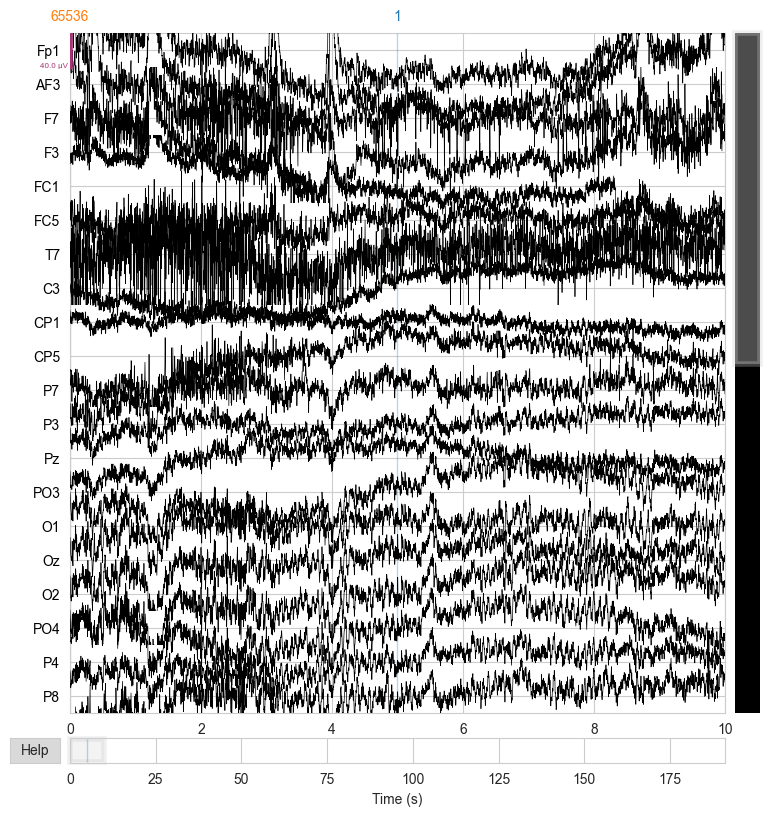

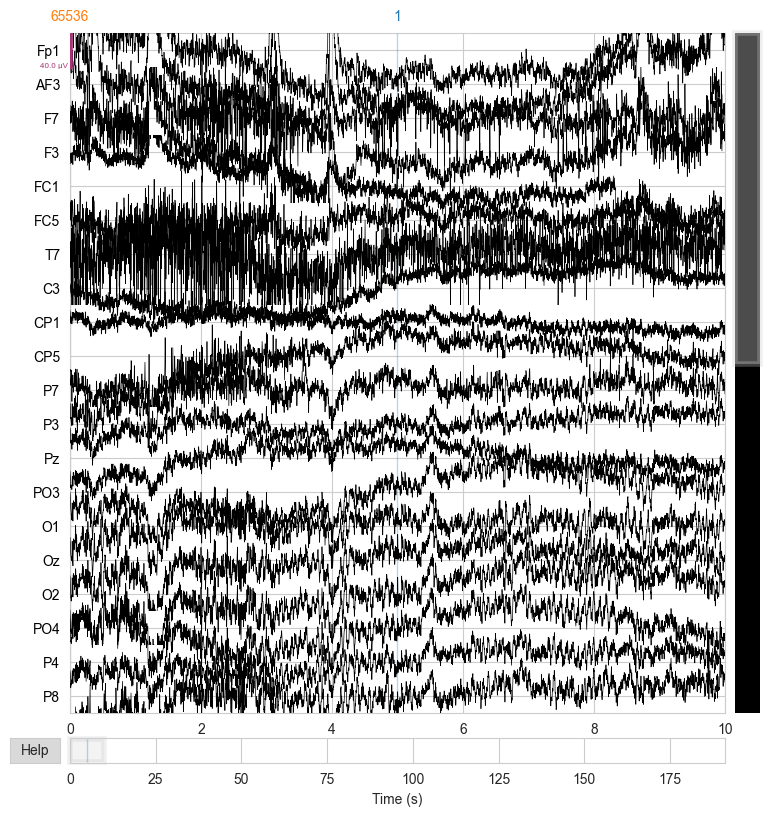

In [50]:
raw_pd.plot()

In [51]:
# We are only interested in the 32-channel EEG data as the responses, so select those channels
resp_channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7',
                 'P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2',
                 'C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']

In [52]:
data_pd = load_bids(root=bids_root, subject=subject_pd, datatype='eeg', task='rest', suffix='eeg', session='off', resp_channels=resp_channels)
data_hc = load_bids(root=bids_root, subject=subject_hc, datatype='eeg', task='rest', suffix='eeg', session='hc', resp_channels=resp_channels)

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_events.tsv.
Reading channel info from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/naplib/io/load_bids.py:94: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw = read_raw_bids(bids_path=bids_path)


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_events.tsv.
Reading channel info from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/naplib/io/load_bids.py:94: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  raw = read_raw_bids(bids_path=bids_path)


  0%|          | 0/2 [00:00<?, ?it/s]

In [53]:
data_pd.mne_info

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 104.0 Hz
 meas_date: 2011-02-18 10:07:18 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 9 items (dict)
>

In [54]:
data_pd[0]

{'event_index': 0,
 'description': '65536',
 'stim': array([[6.5536e+04],
        [6.5536e+04],
        [6.5536e+04],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [1.0000e+00]]),
 'stim_ch_names': ['Status'],
 'resp': array([[ 0.00500388,  0.00073836, -0.00068723, ...,  0.00412316,
          0.0082125 ,  0.00490838],
        [ 0.00500866,  0.00073611, -0.00069192, ...,  0.0041221 ,
          0.00821081,  0.00490738],
        [ 0.00501576,  0.0007387 , -0.0006913 , ...,  0.0041226 ,
          0.00820916,  0.00490494],
        ...,
        [ 0.0049516 ,  0.00069064, -0.00069389, ...,  0.00401407,
          0.00817834,  0.00491629],
        [ 0.00495354,  0.00069808, -0.00071942, ...,  0.00401329,
          0.00817869,  0.00491457],
        [ 0.00494716,  0.00069461, -0.00070064, ...,  0.00400785,
          0.00817428,  0.00490926]]),
 'befaft': [0, 0],
 'sfreq': 512.0,
 'ch_names': ['Fp1',
  'AF3',
  'F7',
  'F3',
  'FC1',
  'FC5',
  'T7',
  'C3',
  'CP1',
  'CP5',
  

### Рассчитаем соотношение альфа и тета ритмов:
Спектральная плотность мощности (PSD, СПМ) в физике и обработке сигналов — функция, описывающая распределение мощности сигнала в зависимости от частоты, то есть мощность, приходящуюся на единичный интервал частоты.

Имеет размерность мощности, делённой на частоту, то есть энергии. Например, в Международной системе единиц (СИ) это Вт/с−1 (Вт·с) или Вт/Гц. 1

Часто термин применяется при описании спектральной мощности потоков электромагнитного излучения или других колебаний в сплошной среде, например, акустических. 1 В этом случае подразумевается мощность на единицу частоты на единицу площади, например: Вт·Гц-1·м-2, часто также Дж·м-2.

Для работы с ритмами мозга MNE python предлагает функцию mne.time_frequency.psd_array_welch. Она реализована в соответствии со статьей Питера Д. Уэлча "Использование быстрого преобразования Фурье для оценки спектров мощности: метод, основанный на усреднении по времени коротких модифицированных периодограмм". Труды IEEE по аудио и электроакустике, 15(2):70-73, 1967.

Вычислим соотношение альфа/Тета в каждом канале. Мы будем использовать логарифмические значения, чтобы коэффициенты выше 1 были положительными, а коэффициенты ниже 1 - отрицательными, что делает полученную "карту" более наглядной.

In [55]:
def log_alpha_theta_ratio(response, sfreq):
    '''response should be of shape (time * channels)'''
    # must transpose response for mne function
    alpha_psd, _ = mne.time_frequency.psd_array_welch(response.T, sfreq, fmin=8, fmax=13, verbose=False) # psd is shape (channels * freqs)
    alpha_psd = alpha_psd.mean(-1)
    
    theta_psd, _ = mne.time_frequency.psd_array_welch(response.T, sfreq, fmin=4, fmax=8, verbose=False) # psd is shape (channels * freqs)
    theta_psd = theta_psd.mean(-1)
    #print(f'{np.mean(np.log(alpha_psd))} {np.mean(np.log(theta_psd))}')
    
    return np.log(alpha_psd / theta_psd)
    

alpha_theta_ratio_pd = [log_alpha_theta_ratio(trial['resp'], trial['sfreq']) for trial in data_pd]
alpha_theta_ratio_hc = [log_alpha_theta_ratio(trial['resp'], trial['sfreq']) for trial in data_hc]

In [56]:
df_pd = pd.DataFrame(alpha_theta_ratio_pd, columns=resp_channels, index=['Parkinson (task1)', 'Parkinson (task2)'])
df_pd.head()

Fp1       AF3        F7        F3       FC1       FC5  \
Parkinson (task1) -2.956091 -2.605477 -1.532497 -1.992585 -0.979684 -0.410979   
Parkinson (task2) -2.312230 -1.803975 -0.641801 -1.113163 -0.459126 -0.309230   

                         T7        C3       CP1       CP5  ...        C4  \
Parkinson (task1) -0.368561 -0.265077 -0.648261 -0.838916  ...  0.450846   
Parkinson (task2) -0.220693 -0.387382  0.209164  0.043153  ...  0.204603   

                         T8       FC6       FC2        F4        F8       AF4  \
Parkinson (task1) -0.111134 -0.305652 -0.414599 -1.810505 -1.664818 -2.619720   
Parkinson (task2)  0.088299 -0.008959 -0.143371 -1.007491 -0.769636 -1.793098   

                        Fp2        Fz        Cz  
Parkinson (task1) -2.810747 -1.821417  0.003271  
Parkinson (task2) -2.209526 -0.891412 -0.197601  

[2 rows x 32 columns]

In [57]:
print(f'Parkinson, task1 mean alpha_theta_ratio: {np.mean(alpha_theta_ratio_pd[0])}')
print(f'Parkinson, task2 mean alpha_theta_ratio: {np.mean(alpha_theta_ratio_pd[1])}')

Parkinson, task1 mean alpha_theta_ratio: -0.8296064946992816
Parkinson, task2 mean alpha_theta_ratio: -0.25411769131286543


In [58]:
df_hc = pd.DataFrame(alpha_theta_ratio_hc, columns=resp_channels, index=['Healthy (task1)', 'Healthy (task2)'])
df_hc.head()

Fp1       AF3        F7        F3       FC1       FC5  \
Healthy (task1) -2.158081 -1.557962 -0.635515 -1.015756 -1.099973 -0.468332   
Healthy (task2) -1.140596 -0.614844 -0.020063 -0.351466 -0.184199  0.099997   

                       T7        C3       CP1       CP5  ...        C4  \
Healthy (task1) -0.263327 -0.471416 -0.368454 -0.166000  ... -0.624862   
Healthy (task2)  0.488001  0.052781  0.176115  0.355984  ...  0.122959   

                       T8       FC6       FC2        F4        F8       AF4  \
Healthy (task1)  0.246523 -0.568634 -0.706732 -1.518856 -0.959792 -2.034258   
Healthy (task2)  0.305460  0.087407 -0.128352 -0.295869 -0.035138 -0.590576   

                      Fp2        Fz        Cz  
Healthy (task1) -2.294857 -1.449469 -0.340760  
Healthy (task2) -1.042259 -0.334008 -0.161981  

[2 rows x 32 columns]

In [59]:
print(f'Healthy, task1 mean alpha_theta_ratio: {np.mean(alpha_theta_ratio_hc[0])}')
print(f'Healthy, task2 mean alpha_theta_ratio: {np.mean(alpha_theta_ratio_hc[1])}')

Healthy, task1 mean alpha_theta_ratio: -0.7072535899807941
Healthy, task2 mean alpha_theta_ratio: -0.028340708202067653


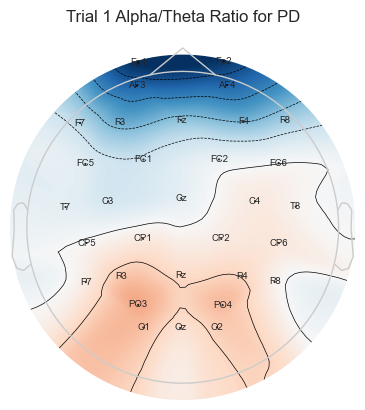

In [60]:
# Сначала нам нужно установить монтаж (т. е. расположение электродов), чтобы каналы можно было правильно нанести на график
# Здесь мы устанавливаем стандартную систему 10-20, но доступно много вариантов, если данные были записаны в другом
# монтаже. См. https://mne.tools/dev/generated/mne.channels.make_standard_montage.html
data_pd.mne_info.set_montage('standard_1020')

fig, ax = plt.subplots()
ax.set_title('Trial 1 Alpha/Theta Ratio for PD')
plot_topomap(alpha_theta_ratio_pd[1], data_pd.mne_info, axes=ax, sensors=True, names=resp_channels)
plt.show()

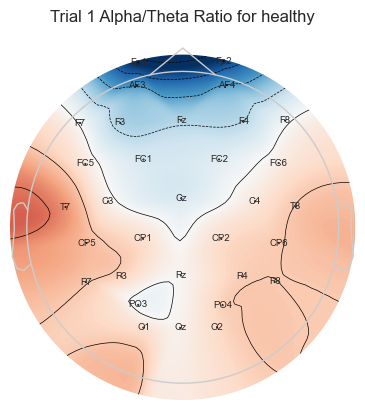

In [61]:
data_hc.mne_info.set_montage('standard_1020')

fig, ax = plt.subplots()
ax.set_title('Trial 1 Alpha/Theta Ratio for healthy')
plot_topomap(alpha_theta_ratio_hc[1], data_hc.mne_info, axes=ax, sensors=True, names=resp_channels)
plt.show()

## Избавляемся от зашумленных данных и разбиваем данные на короткие эпохи

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)

Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.00010340581484039399}
Using data from preloaded Raw for 192 events and 512 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'FC6', 'F8', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'T8', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 

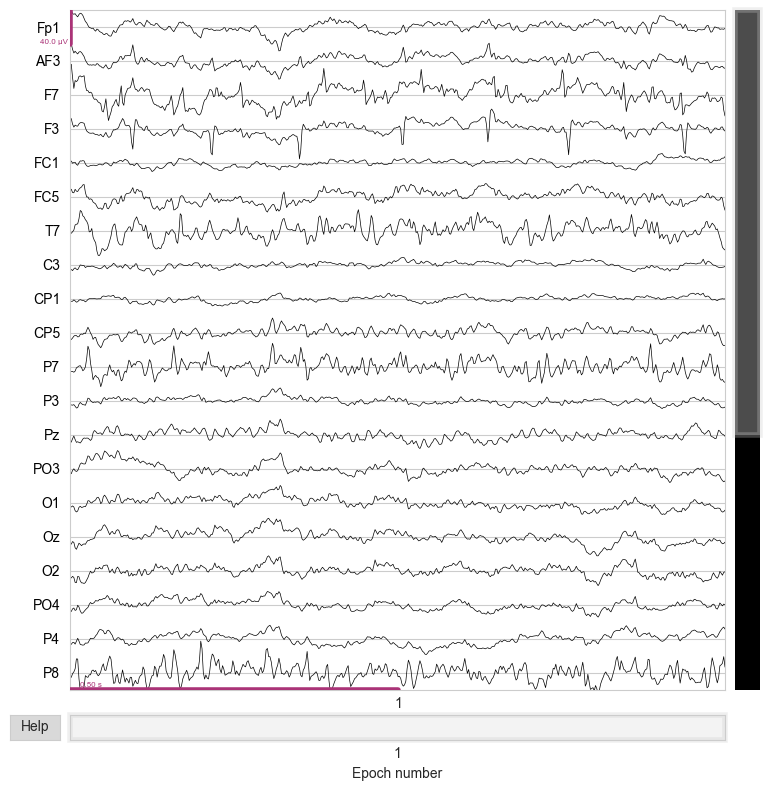

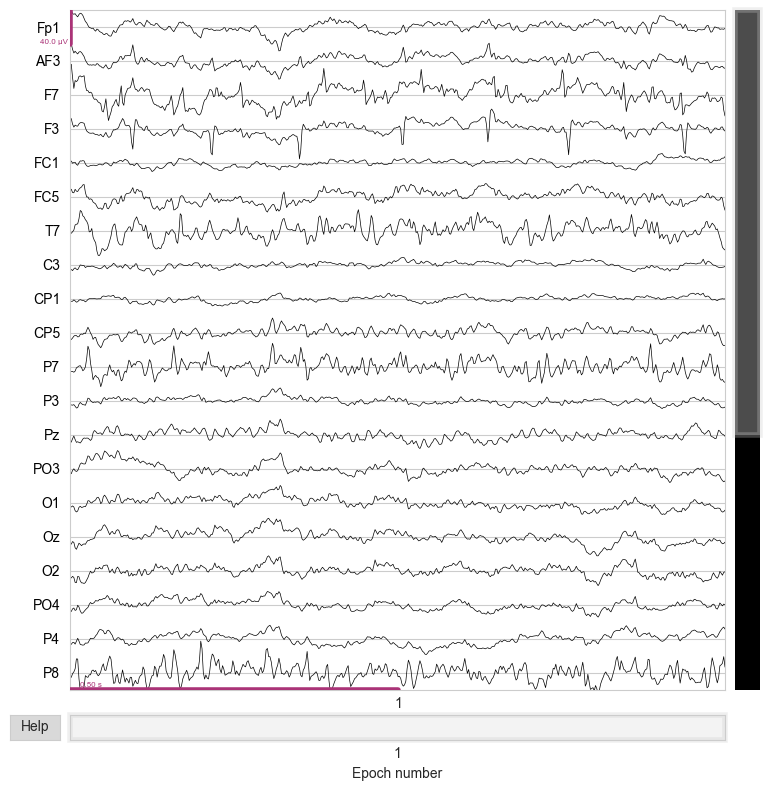

In [62]:
subject_hc = 'hc7'

raw_hc = mne.io.read_raw_bdf('/Users/evakhromeeva/mne_data/ds002778/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf', preload=True)
raw_hc.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8',
                                  'Status']) #drop extra channels
raw_hc.set_eeg_reference(ref_channels='average')
raw_hc.filter(0.5, None, fir_design='firwin',phase='zero-double') #remove drifts

epochs_hc = mne.make_fixed_length_epochs(raw_hc, duration=1.0, preload=False, proj=True)
reject = get_rejection_threshold(epochs_hc)
print('The rejection dictionary is %s' % reject)
epochs_hc.drop_bad(reject=reject)

epochs_hc[0].plot()

In [63]:
print(epochs_hc.info)
print(len(epochs_hc))

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: True
 highpass: 0.5 Hz
 lowpass: 104.0 Hz
 meas_date: 2011-02-25 13:25:06 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>
154


Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 97791  =      0.000 ...   190.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)

Not setting metadata
191 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 191 events 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.0001648947861533053}
Using data from preloaded Raw for 191 events and 512 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'T8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['T7', 'FC6']
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'AF4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'F3', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'T8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3

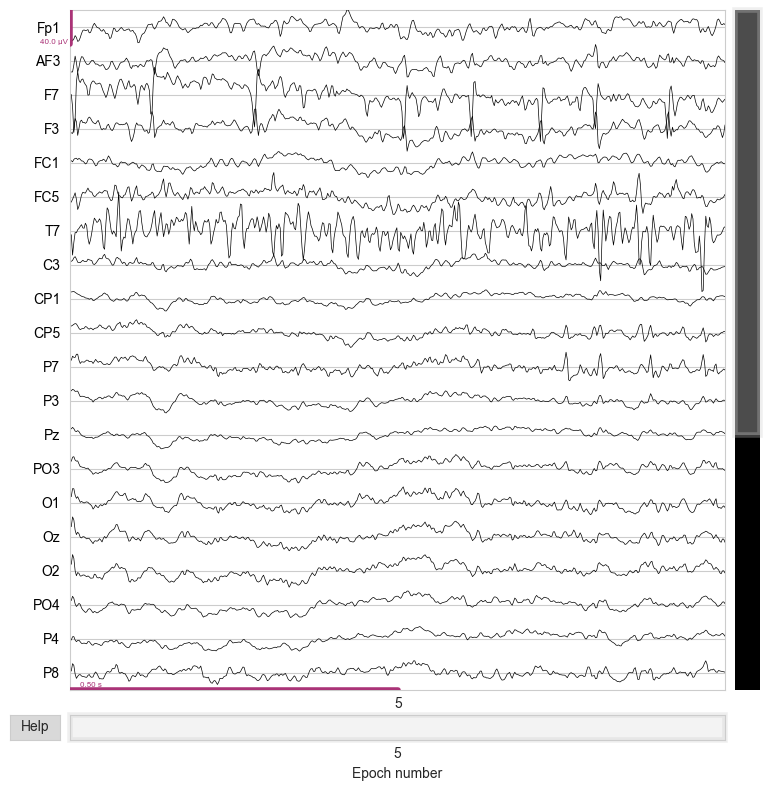

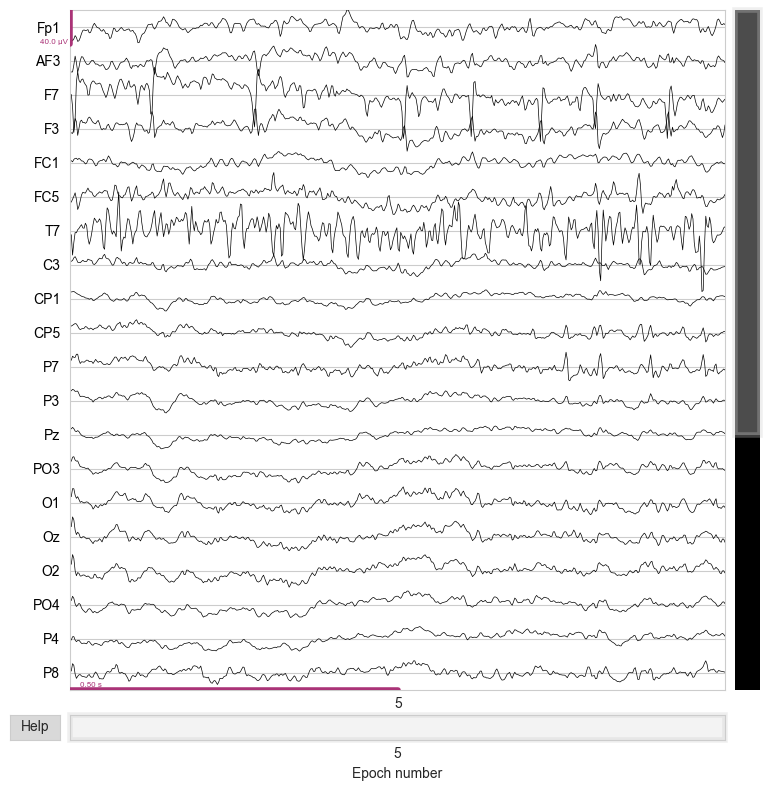

In [64]:
raw_pd = mne.io.read_raw_bdf('/Users/evakhromeeva/mne_data/ds002778/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf', preload=True)
raw_pd.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8',
                                  'Status']) #drop extra channels
raw_pd.set_eeg_reference(ref_channels='average')
raw_pd.filter(0.5, None, fir_design='firwin',phase='zero-double') #remove drifts

epochs_pd = mne.make_fixed_length_epochs(raw_pd, duration=1.0, preload=False, proj=True)
reject = get_rejection_threshold(epochs_pd)
print('The rejection dictionary is %s' % reject)
epochs_pd.drop_bad(reject=reject)

epochs_pd[0].plot()

In [65]:
print(epochs_pd.info)
print(len(epochs_pd))

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: True
 highpass: 0.5 Hz
 lowpass: 104.0 Hz
 meas_date: 2011-02-18 13:07:18 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 1 item (dict)
>
77


/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/mne/viz/epochs.py:434: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  this_fig = figure(layout="constrained")


Using data from preloaded Raw for 77 events and 512 original time points ...
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
77 matching events found
No baseline correction applie

/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_86352/3370171048.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  event_related_plot = epochs_pd.plot_image(picks=resp_channels)
/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_86352/3370171048.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  event_related_plot = epochs_pd.plot_image(picks=resp_channels)
/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_86352/3370171048.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  event_related_plot = epochs_pd.plot_image(picks=resp_channels)
/var/folders/vb/ln0by8yd5g188n3xwgtwx5dr0000gn/T/ipykernel_86352/3370171048.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  event_related_plot = epochs_pd.plot_image(picks=resp_channe

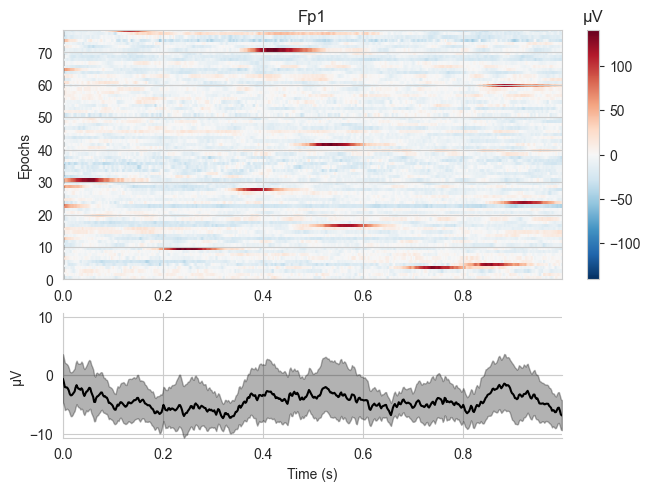

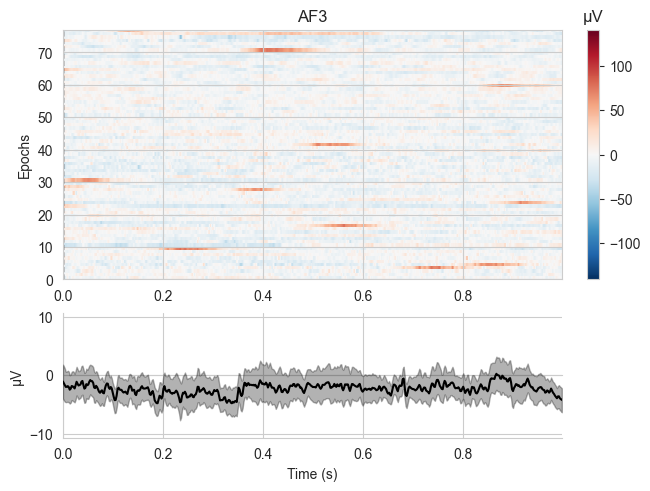

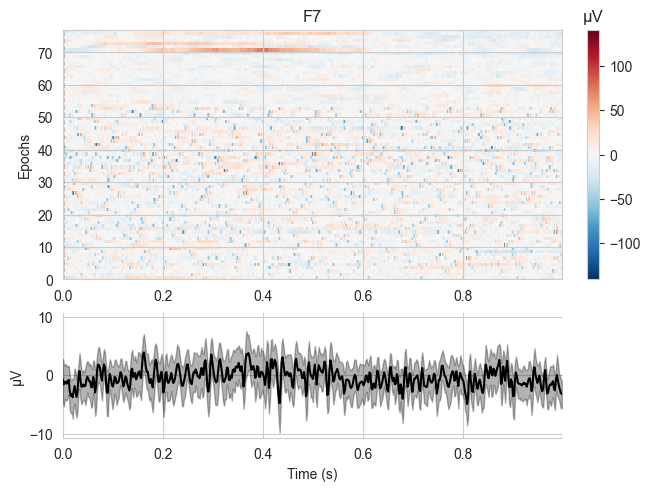

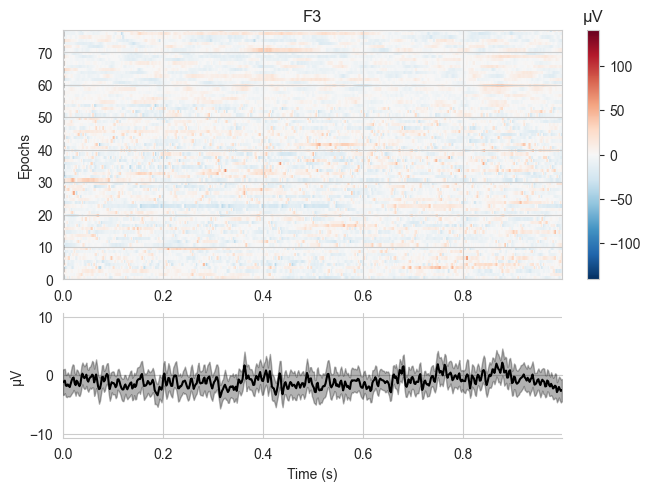

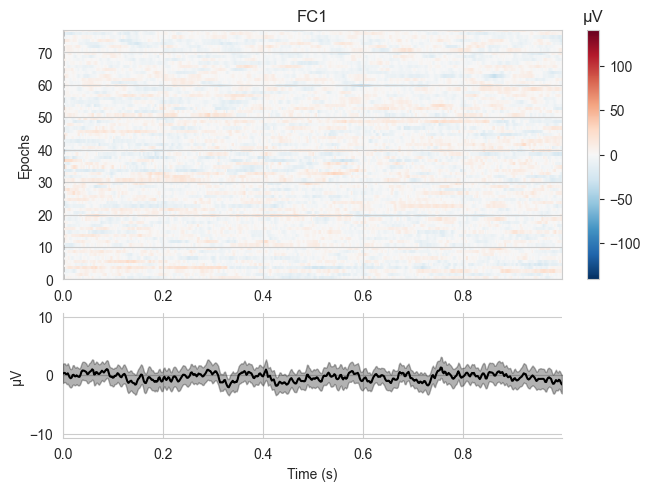

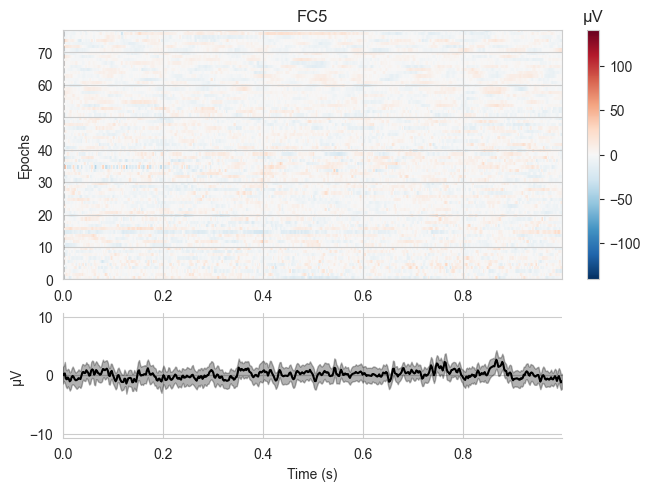

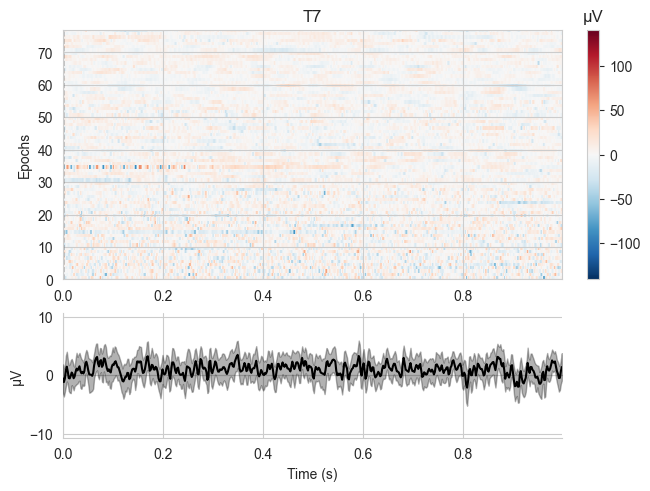

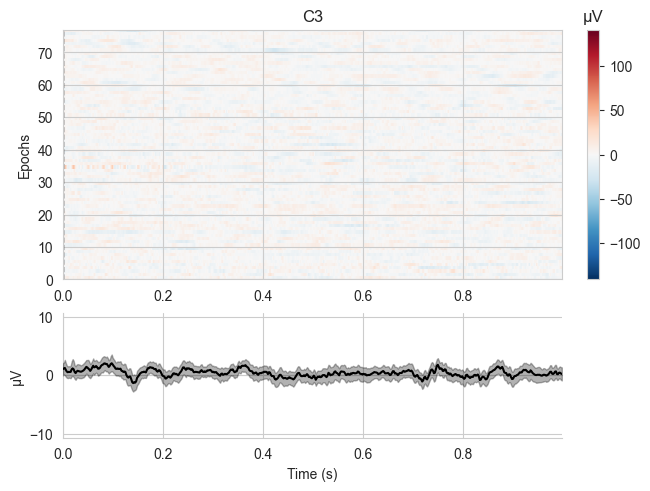

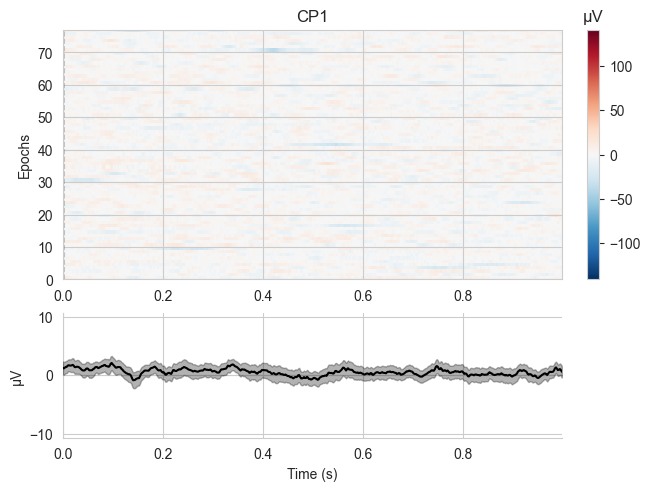

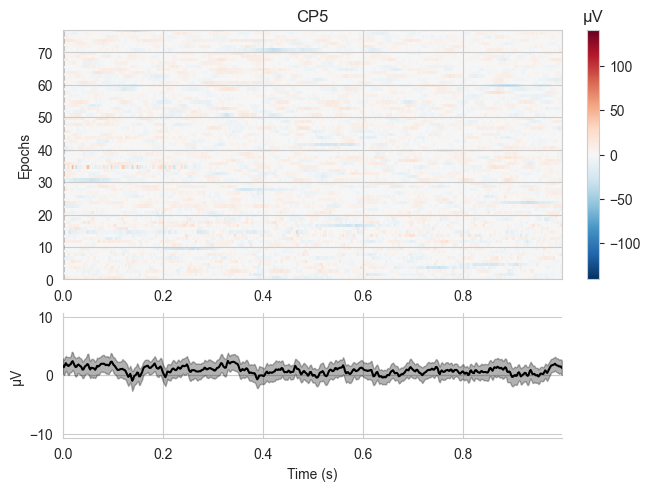

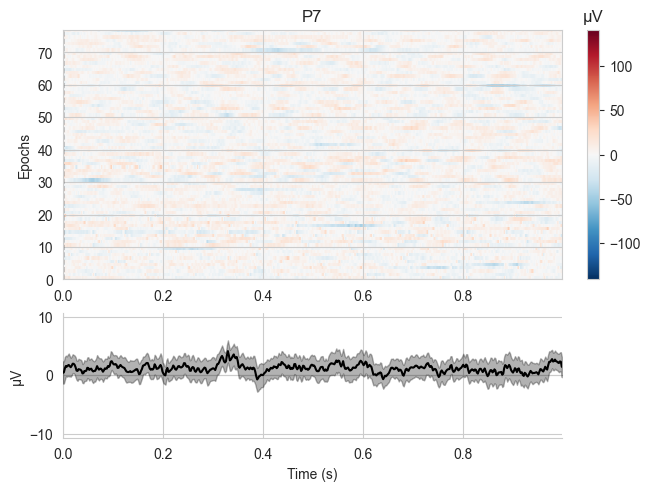

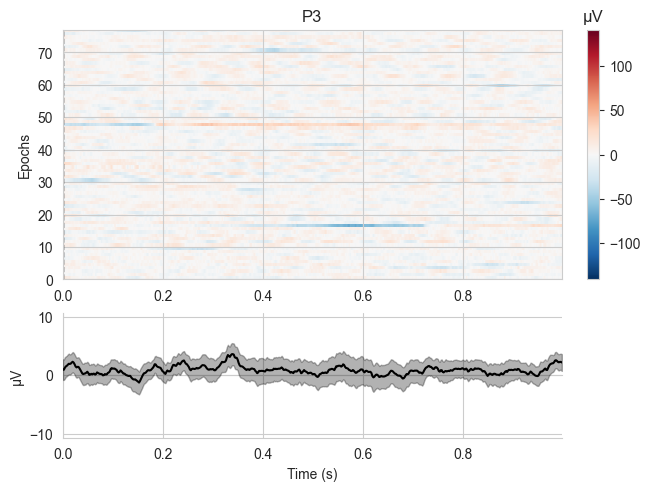

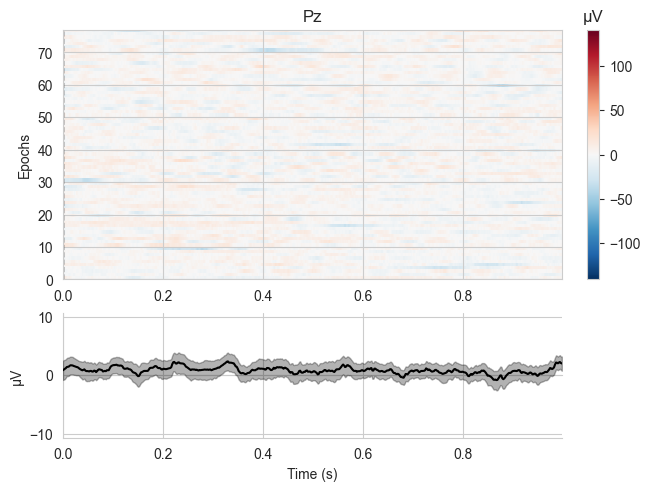

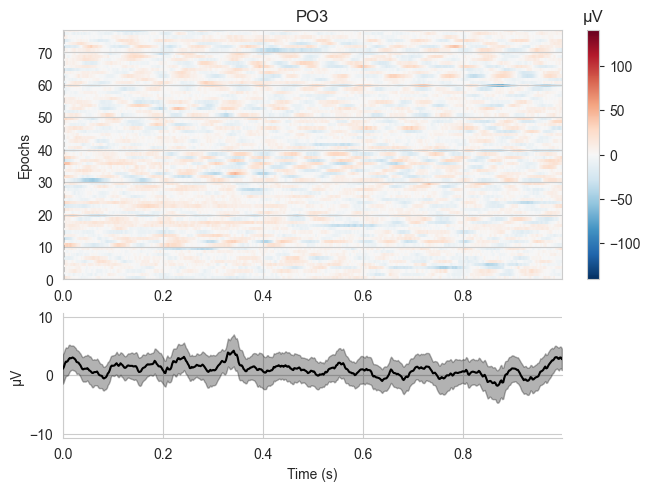

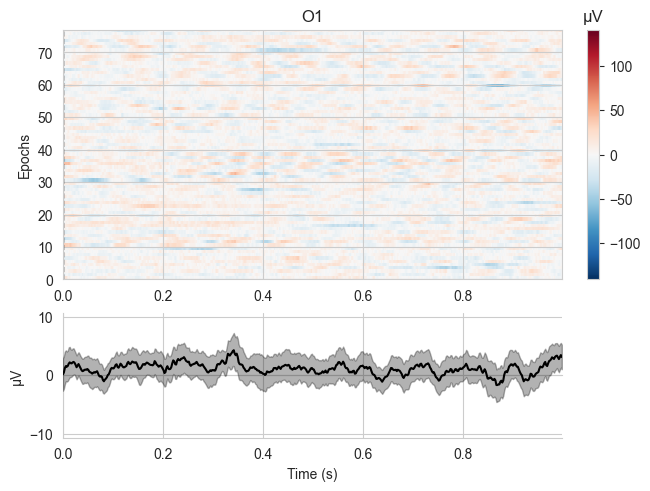

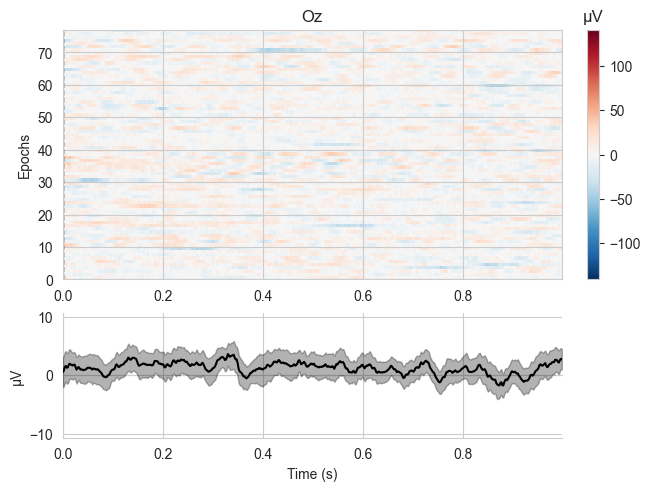

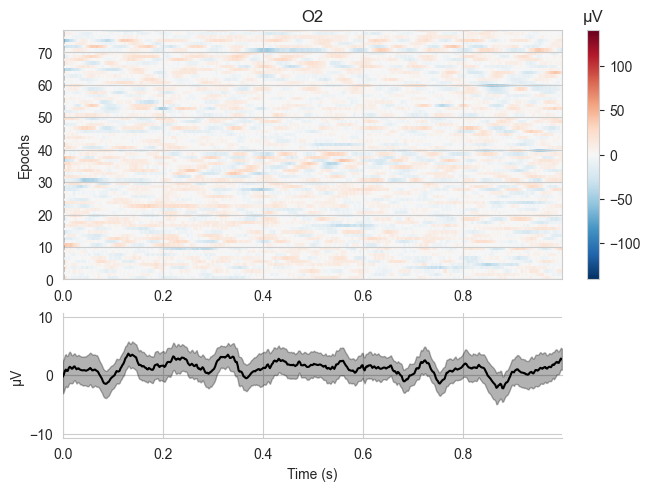

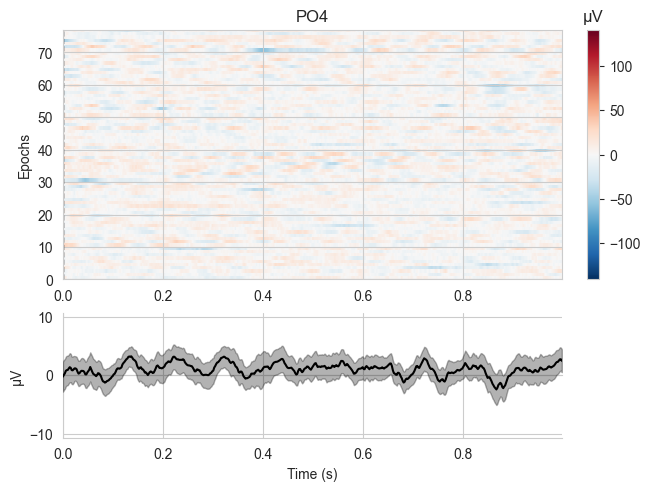

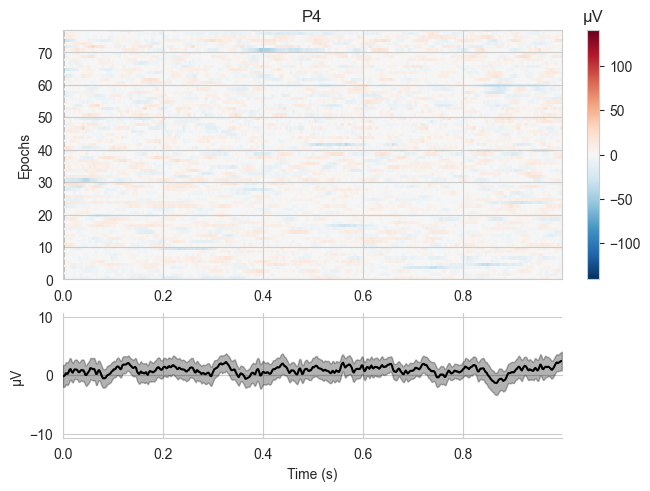

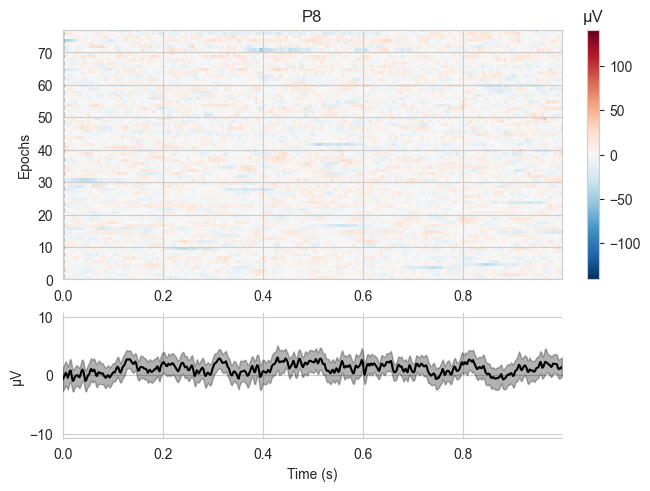

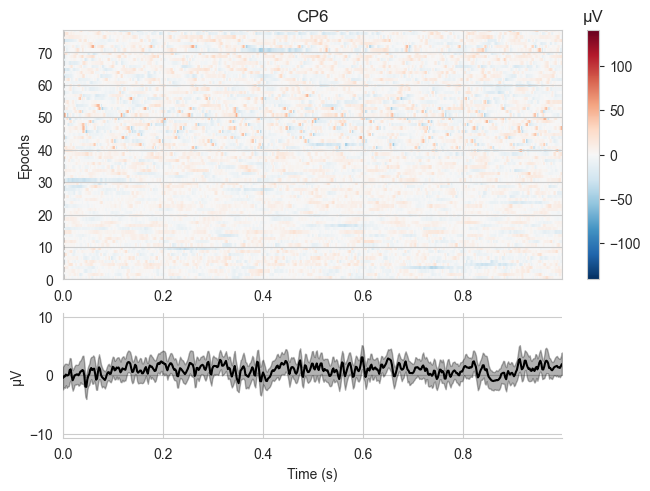

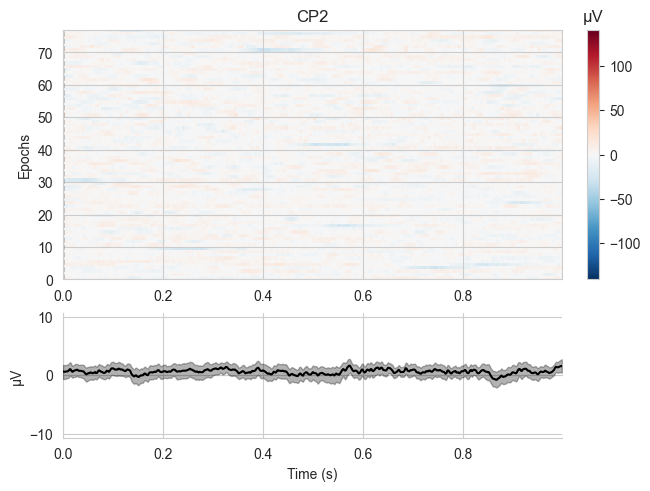

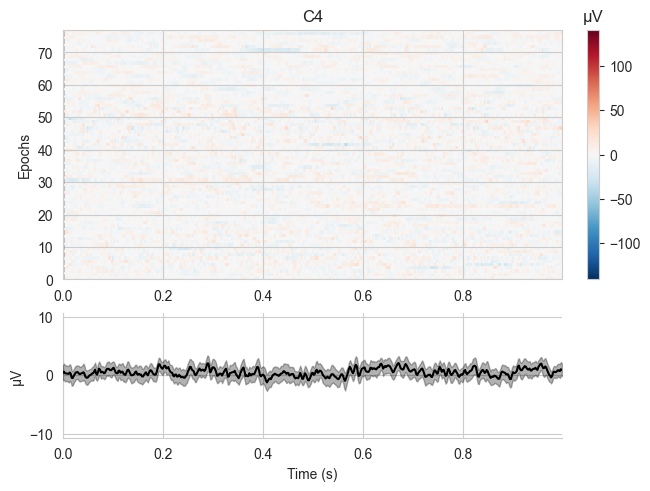

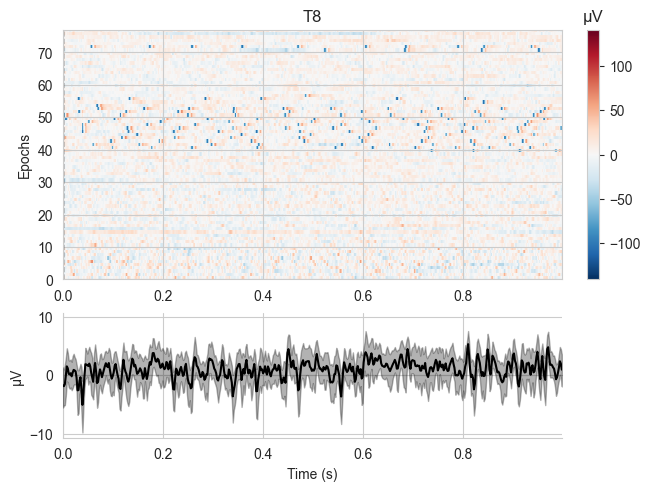

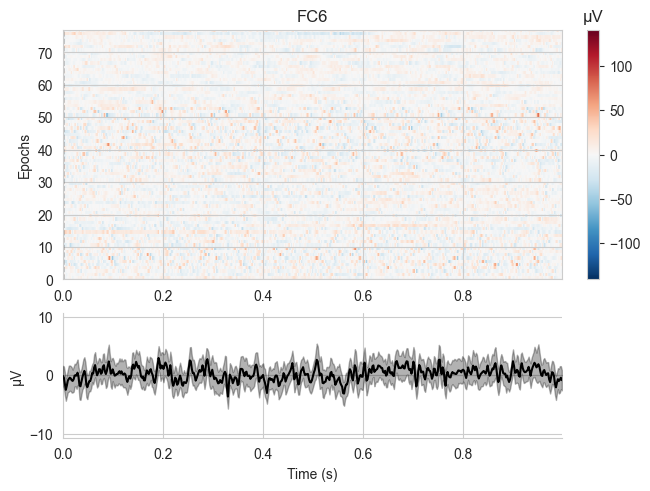

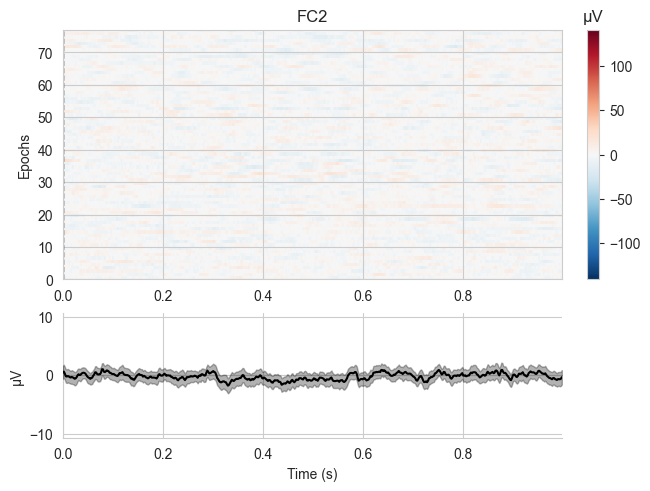

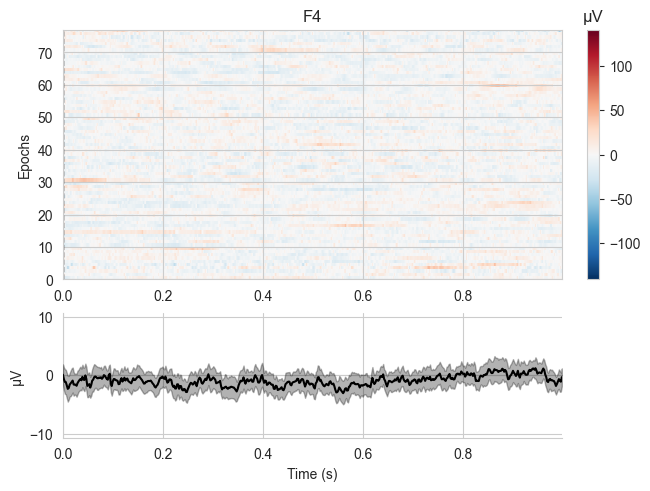

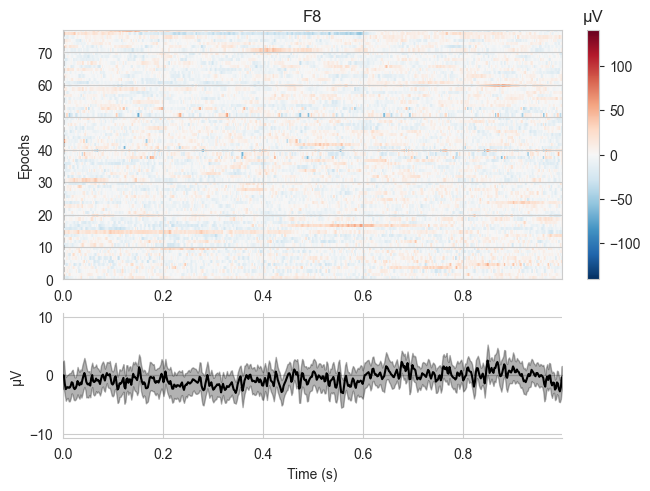

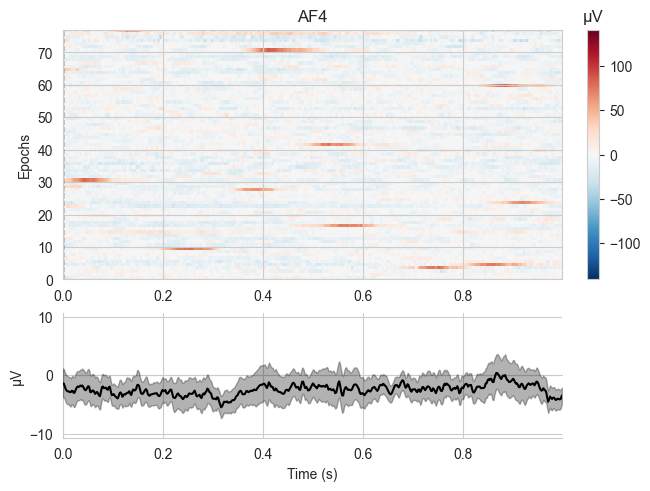

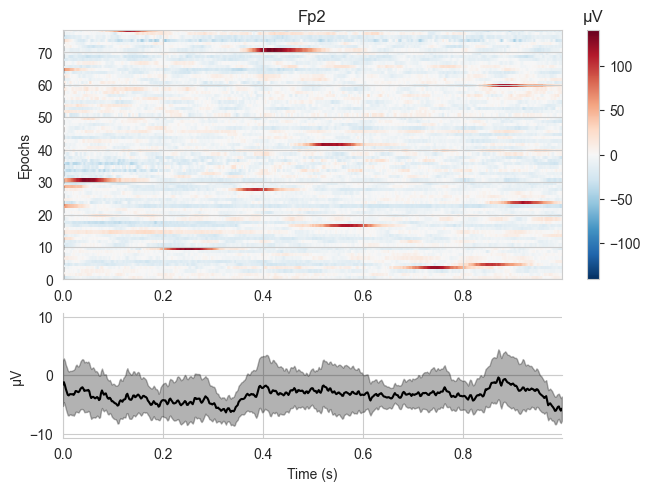

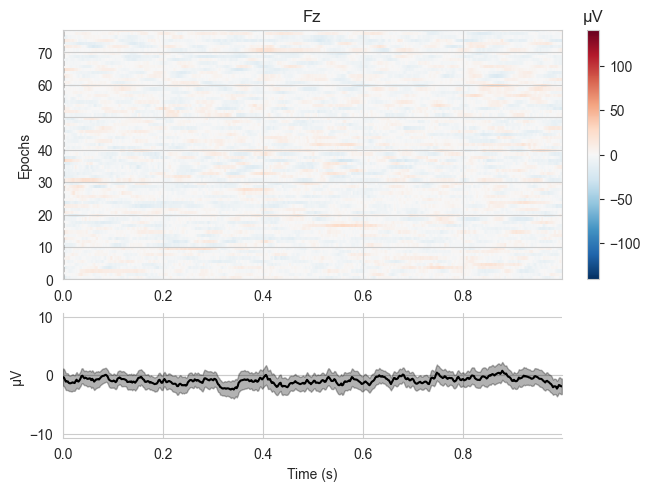

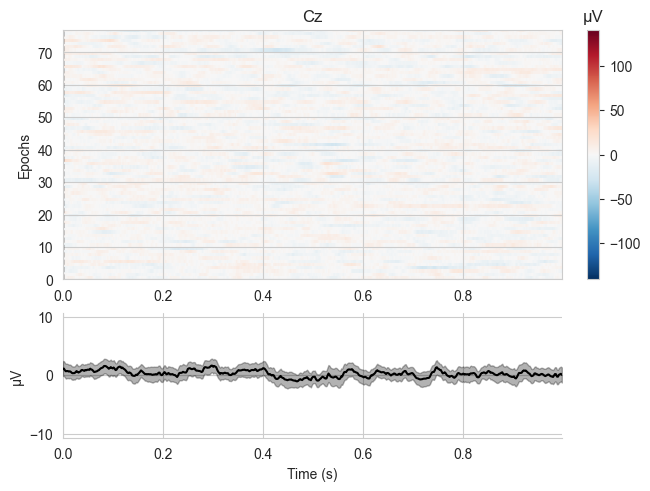

In [66]:
event_related_plot = epochs_pd.plot_image(picks=resp_channels)

In [67]:
#epochs_joined = epochs_hc + epochs_pd
print(epochs_hc.events.size)
print(epochs_pd.events.size)

462
231


In [68]:
print(f'HC epochs shape: {epochs_hc.events[0]}, PD epochs shape: {epochs_pd.events[0]}')

HC epochs shape: [512   0   1], PD epochs shape: [2560    0    1]


Для того, чтобы данными было удобнее манипулировать, мне хочется сделать из них не объект класса Epoch, а обычный тензор (точнее, np.array). Для этого у Epoch есть метод get_data - он может принимать некоторые параметры, а может и работать с дефолтными (см. https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.get_data)

In [69]:
pd_data1 = epochs_pd.get_data()
pd_data1.shape

Using data from preloaded Raw for 77 events and 512 original time points ...


(77, 32, 512)

In [70]:
hc_data = epochs_hc.get_data()
hc_data.shape

Using data from preloaded Raw for 154 events and 512 original time points ...


(154, 32, 512)

Эпох для болезни Паркинсона в 2 раза меньше, чем эпох с данными здоровых. Нужно сбалансировать эти эпохи.

In [71]:
raw_pd2 = mne.io.read_raw_bdf('/Users/evakhromeeva/mne_data/ds002778/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf', preload=True)
raw_pd2.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8',
                                  'Status']) #drop extra channels
raw_pd2.set_eeg_reference(ref_channels='average')
raw_pd2.filter(0.5, None, fir_design='firwin',phase='zero-double') #remove drifts

epochs_pd2 = mne.make_fixed_length_epochs(raw_pd2, duration=1.0, preload=False, proj=True)
reject = get_rejection_threshold(epochs_pd2)
print('The rejection dictionary is %s' % reject)
epochs_pd2.drop_bad(reject=reject)

Extracting EDF parameters from /Users/evakhromeeva/mne_data/ds002778/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102399  =      0.000 ...   199.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.00013482398702397005}
Using data from preloaded Raw for 200 events and 512 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FC5', 'T8', 'FC6', 'F8', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'T7', 'CP5', 'CP6', 'C4', 'T8', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'T7', 'CP5', 'F8']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp

<Epochs | 121 events (all good), 0 – 0.998 s (baseline off), ~35 kB, data not loaded,
 '1': 121>

In [72]:
pd_data2 = epochs_pd2.get_data()
pd_data2.shape

Using data from preloaded Raw for 121 events and 512 original time points ...


(121, 32, 512)

## Собираем train и test выборки

In [73]:
# Собираем тестовые данные, объединяя загруженные данные здоровых людей и с Паркинсоном (0 - нет болезни, 1 - есть):
X_train = np.zeros((77 + 121 + 154, 32, 512))
y_train = np.zeros((77 + 121 + 154))

# ToDo: заполнить
X_test = np.zeros((77 + 121 + 154, 32, 512))
y_test = np.zeros((77 + 121 + 154))

for i in range(77):
    X_train[i] = pd_data1[i]
    y_train[i] = 1
for i in range(121):
    X_train[77 + i] = pd_data2[i]
    y_train[77 + i] = 1
for i in range(154):
    X_train[77 + 121 + i] = hc_data[i]
    y_train[77 + 121 + i] = 0


print(X_train.shape)
print(X_train.dtype)
print(y_train.shape)
print(y_train.dtype)

(352, 32, 512)
float64
(352,)
float64


## Исследование с помощью методов PCA, ICA, truncated SVD, t-SNE и MDS для попытки понижения размерности входных данных

In [74]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters = 5) # предложим разделить на 5 кластеров - по 5 типам волн (альфа, бета, гамма, дельта и тета)
cluster = kmeans.fit_predict(X_train[0])

#### PCA

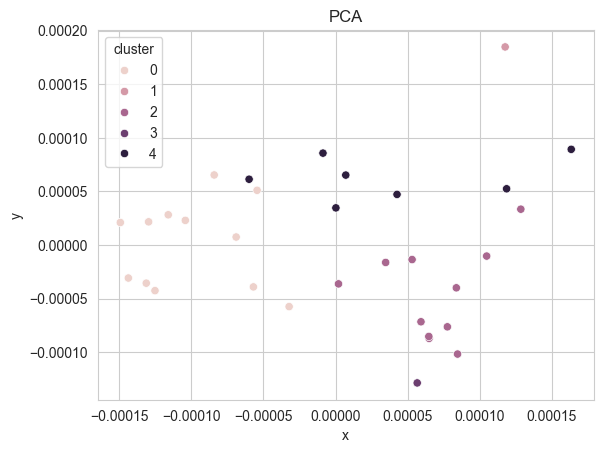

In [75]:
pca2D = PCA(n_components=2)
#dimensions
pca_2D = pca2D.fit_transform(X_train[0])
pca2D_df = pd.DataFrame(data = pca_2D, columns = ['x', 'y'])

pca2D_df['cluster'] = cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca2D_df)
plt.title("PCA")
plt.show()

#### ICA

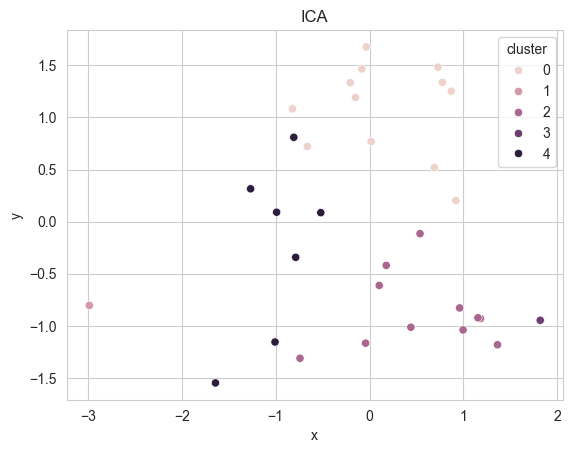

In [76]:
ica2D = FastICA(n_components=2)
ica_data2D = ica2D.fit_transform(X_train[0])
ica2D_df = pd.DataFrame(data =  ica_data2D,columns = ['x', 'y'])

ica2D_df['cluster'] = cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=ica2D_df)
plt.title("ICA")
plt.show()

#### truncated SVD

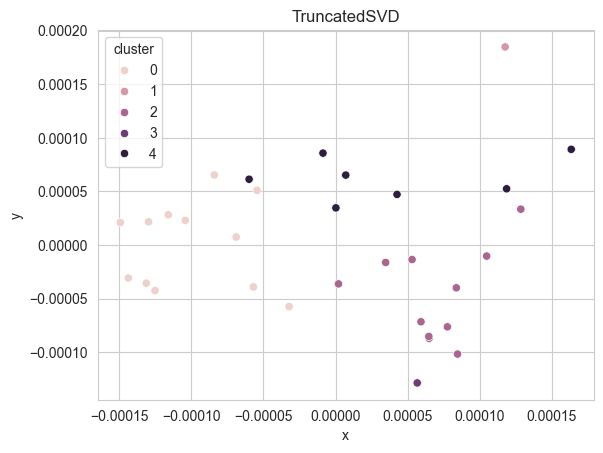

In [77]:
tsvd2D = TruncatedSVD(n_components=2)
tsvd_data2D = tsvd2D.fit_transform(X_train[0])
tsvd2D_df = pd.DataFrame(data =  tsvd_data2D, columns = ['x', 'y'])

tsvd2D_df['cluster']  = cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=tsvd2D_df)
plt.title("TruncatedSVD")
plt.show()

#### t-SNE

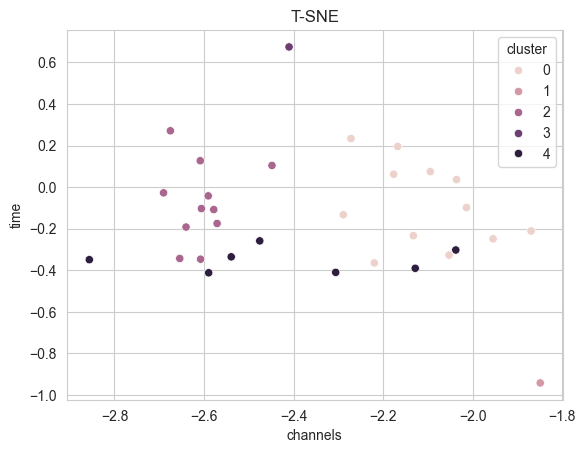

In [78]:
tsne2D = TSNE(n_components=2)
tsne_data2D = tsne2D.fit_transform(X_train[1]) # epoch 0
tsne2D_df = pd.DataFrame(data =  tsne_data2D, columns = ['channels', 'time'])

tsne2D_df['cluster'] = cluster

sns.scatterplot(x='channels', y='time', hue='cluster', data=tsne2D_df)
plt.title("T-SNE")
plt.show()

#### MDS

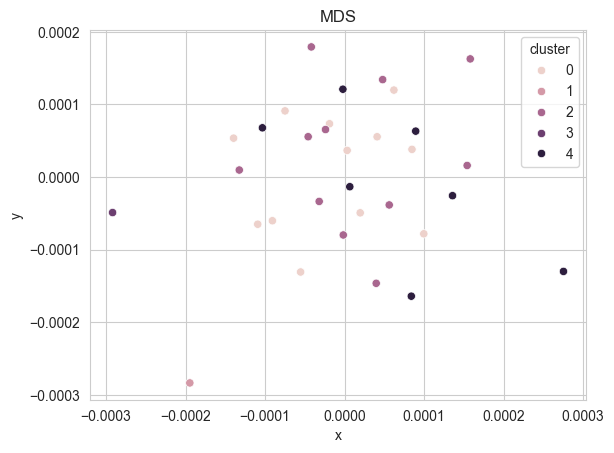

In [79]:
mds2D = MDS(n_components=2)

mds_data2D = mds2D.fit_transform(X_train[0])
mds2D_df = pd.DataFrame(data =  mds_data2D, columns = ['x', 'y'])

mds2D_df['cluster'] = cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=mds2D_df)
plt.title("MDS")
plt.show()

## Подготовка пайплайна обучения

In [80]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #'mps'
print(DEVICE)

cpu


In [81]:
class Dataset(BaseDataset):
    CLASSES = ['healthy', 'parkinson']
    def __init__(
                self,
                X,
                y,
                classes=None,
                preprocessing=None,
        ):
            self.len = len(X[:,0,0])
            # convert str names to class values
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
            self.X = X
            self.y = y
            self.preprocessing = preprocessing

    def __getitem__(self, i):
        item = tensor(self.X[i], dtype=torch.double)
        result = tensor(self.y[i], dtype=torch.double)

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(item=X[i])
            X[i] = sample

        return item, result

    def __len__(self):
        return self.len

In [82]:
CLASSES = ['healthy', 'parkinson']

train_dataset = Dataset(X_train, y_train, classes=CLASSES)
test_dataset = Dataset(X_test, y_test, classes=CLASSES)

item, result = train_dataset[4] # some sample
print(f'X_train[4] shape = {item.shape}, y_train[4] = {result}')
print(f'X_train[4] dtype = {item.dtype}, y_train[4] dtype = {result.dtype}')

X_train[4] shape = torch.Size([32, 512]), y_train[4] = 1.0
X_train[4] dtype = torch.float64, y_train[4] dtype = torch.float64


In [83]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32 * 512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        self.double()
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        
model = NeuralNetwork().to(DEVICE)

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16384, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [84]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.001 ) # momentum=0.9

In [85]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 2000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [86]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [87]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [88]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(train_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.554014  [    0/  352]


/Users/evakhromeeva/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Accuracy: 43.8%, Avg loss: 0.509690 

Epoch 2
-------------------------------
loss: 0.537872  [    0/  352]
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.495295 

Epoch 3
-------------------------------
loss: 0.604470  [    0/  352]
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.481698 

Epoch 4
-------------------------------
loss: 0.481698  [    0/  352]
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.468851 

Epoch 5
-------------------------------
loss: 0.417667  [    0/  352]
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.456693 

Epoch 6
-------------------------------
loss: 0.506244  [    0/  352]
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.445205 

Epoch 7
-------------------------------
loss: 0.541135  [    0/  352]
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.434360 

Epoch 8
-------------------------------
loss: 0.411148  [    0/  352]
Test Error: 
 Accuracy: 43.8%, Avg loss: 0.424111 

Epoch 9
-------------------------------
loss: 0.379183  [    0/  352]
Test Error: 
 Accuracy: 